# Mulit-armed bandit

Observation are binary values (reward, no-reward) sampled from the binomial distributions with dynamic expected value $\vec{p}_{t,n}$, where $n$ denotes the chosen bandit. At each time step the reward expectations across bandits would either stay unchanged with $1-\rho$ or change to a new value (drawn from an uniform distribution over space of categorical distributions) with probability $\rho$.

In [1]:
import numpyro as npyro
import numpyro.distributions as dist
import jax.numpy as np
from jax import random, lax, nn, ops

In [2]:
n = 10
rho = .005
B1 = (1 - rho) * np.eye(n) + rho * (np.ones((n, n)) - np.eye(n))/(n-1)
B1 = np.broadcast_to(B1, (1, n, n))

B2 = np.eye(n)[:, None, :]
B2 = np.broadcast_to(B2, (n, n + 1, n))
B2 = np.concatenate([np.zeros((n, n + 1, 1)), B2], -1)

B = [B1, B2]

eps = .6
base = .2
# n, n + 1 | 2
A1 = np.concatenate([np.stack([np.ones((n)), np.zeros((n))], -1)[:, None],
                     np.stack([1 - (np.eye(n) * eps + base * np.ones((n, n))), 
                               np.eye(n) * eps + base * np.ones((n, n))], -1)], 
                    -2)

# n, n + 1 | n + 1
A2 = np.broadcast_to(np.eye(n + 1)[None], (n, n + 1, n + 1))

A = [A1, A2]

# 3 | 2
A3 = np.array([[1 - base, base], [1 - base - eps, base + eps], [1., 0.]])

# n, n + 1| 3
p3 = np.zeros((n, n + 1, 1))
p3 = ops.index_update(p3, ops.index[:, 0], 1.)
A4 = np.concatenate([np.concatenate([np.zeros((n, 1, 2)),
                     np.stack([1 - np.eye(n), 
                               np.eye(n)], -1)], -2),
                     p3], 
                    -1)

print(np.all(np.isclose(np.einsum('ijk,ko->ijo', A4, A3), A1)))
print(np.log(np.einsum('i,ij->j', np.array([.01, .95, .04]), A3)))

True
[-1.4354845  -0.27180877]


In [3]:
def log(x):
    return np.nan_to_num(np.log(x))

def logit(probs):
    lp = log(probs)
    return lp - np.nan_to_num(lp.sum(-1)[:, None])/probs.shape[-1]


def process(t, choices, states, rng_key):
    new_states = []
    axis = (0, 1)
    for i, b in enumerate(B):
        rng_key, _rng_key = random.split(rng_key)
        probs = lax.index_take(b, [choices[i], states[i]], axis)
        new_states.append(random.categorical(_rng_key, log(probs)))
        
       
    new_states = np.stack(new_states, 0)
    
    axis = tuple(range(states.shape[0]))
    outcomes = []
    for a in A:
        rng_key, _rng_key = random.split(rng_key)
        probs = lax.index_take(a, new_states, axis)
        outcomes.append(random.categorical(_rng_key, log(probs)))
    
    outcomes = np.stack(outcomes, 0)
    
    return outcomes, new_states

def model(t, agent, outcomes, choices, rng_key):
    logits = agent.update_beliefs(t, outcomes, choices)
    new_choices = []
    for logit in logits:
        rng_key, _rng_key = random.split(rng_key)
        new_choices.append(random.categorical(_rng_key, logit))
    
    return np.stack(new_choices, 0)

class Agent(object):
    def __init__(self, 
                 N, 
                 na, 
                 gamma=1., 
                 U=np.array([-1., 1.]), 
                 C=np.log(np.array([.01, .95, .04])), 
                 type='random', 
                 logging=False):
        
        self.N = N
        self.na = na
        self.type = type
        self.U = U
        self.C = C
        self.gamma = gamma
        
        self.s1 = np.ones((N, na))/na
        self.s2 = np.zeros(N, dtype=np.int32)
        
        self.logging = logging
        if self.logging:
            self.prior = {"s1": [self.s1]}
        
    def posterior_probs(self, outcomes, choices):
        location = outcomes[-1]
        reward = outcomes[-2]
        
        likelihood = lax.index_take(A1, [location, reward], (1, 2))
        
        b = B1[choices[0]]
        prediction = np.einsum('nij,ni->nj', b, self.s1)
        assert prediction.shape == likelihood.shape
        
        posterior = likelihood * prediction
        posterior /= posterior.sum(-1)[:, None]
        
        self.s1 = posterior
        self.s2 = location
        
        if self.logging:
            self.prior['s1'].append(posterior)
        
    def thompson_sampling(self):
        probs = np.einsum('ni,ij->nj', self.s1, np.eye(self.na))
        return self.gamma * logit(probs)
    
    def expected_free_energy(self):
        qs1 = np.einsum('ni,ij->nj', self.s1, B1[0])
        qs2_pi = B2[:, self.s2].swapaxes(0, 1)
        
        H_s = - np.sum(np.nan_to_num(np.log(A1)) * A1, -1) - np.sum(np.nan_to_num(np.log(A2)) * A2, -1)
        H = np.einsum('ni,npj,ij->np', qs1, qs2_pi, H_s)
        
        qo_pi = np.einsum('ni,npj,ijo->npo', qs1, qs2_pi, A1)
        
        D = np.sum((np.nan_to_num(np.log(qo_pi)) - self.U) * qo_pi, -1)
        
        return self.gamma * (-D - H)
    
    def expected_free_energy2(self):
        
        qs1 = np.einsum('ni,ij->nj', self.s1, B1[0])
        qs2_pi = B2[:, self.s2].swapaxes(0, 1)
        
        qc_pi = np.einsum('ni,npj,ijc->npc', qs1, qs2_pi, A4)
        
        H_c = - np.sum(np.nan_to_num(np.log(A3)) * A3, -1)
        H = np.einsum('npc,c->np', qc_pi, H_c)
        
        D = np.sum((np.nan_to_num(np.log(qc_pi)) - self.C) * qc_pi, -1)
        
        return self.gamma * (-D - H)
        
    def update_beliefs(self, t, outcomes, choices):
        N = self.N
        if self.type == 'random':
            return [np.zeros((N, 1)), np.zeros((N, self.na))]
        else:
            self.posterior_probs(outcomes, choices)
            if self.type == 'thompson':
                logits = self.thompson_sampling()
            elif self.type == 'EFE_bound':
                logits = self.expected_free_energy()
            elif self.type == 'EFE_exact':
                logits = self.expected_free_energy2()
            else:
                logits = np.zeros((N, self.na))
            
            return [np.zeros((N, 1)), logits]            
            
    
def simulator(agent, process, model, N=100, trials=1000):
    
    rng_key = random.PRNGKey(4483342)
    
    states = np.zeros((2, N), dtype=np.int32)
    outcomes = np.zeros((2, N), dtype=np.int32)
    choices = np.zeros((2, N), dtype=np.int32)
    
    sequence={
        'outcomes': [],
        'choices': [],
        'states': []
    }
    carry = (outcomes, choices, states, rng_key)
    for t in np.arange(trials):
        outcomes, choices, states, rng_key = carry
        
        rng_key, _rng_key = random.split(rng_key)
        new_choices = model(t, agent, outcomes, choices, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        new_outcomes, new_states = process(t, new_choices, states, _rng_key)
        
        sequence['outcomes'].append(new_outcomes)
        sequence['choices'].append(new_choices)
        sequence['states'].append(new_states)
        carry = (new_outcomes, new_choices, new_states, rng_key)
    
    for key in sequence:
        sequence[key] = np.stack(sequence[key], 0)
    
    return sequence

In [4]:
N = 100
agent = Agent(N, n, type='random')
sequence = simulator(agent, process, model, N=N)

correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
regret_random = eps * (1 - correct)

In [5]:
agent = Agent(N, n, type='thompson')
sequence = simulator(agent, process, model, N=N)
correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
regret_thompson = eps * (1 - correct)

U = np.log(np.einsum('i,ij->j', np.array([.01, .95, .04]), A3))
agent = Agent(N, n, gamma=2., U=U, type='EFE_bound')
sequence = simulator(agent, process, model, N=N)
correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
regret_fe_bound = eps * (1 - correct)

agent = Agent(N, n, gamma=2., type='EFE_exact')
sequence = simulator(agent, process, model, N=N)
correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
regret_fe_exact = eps * (1 - correct)

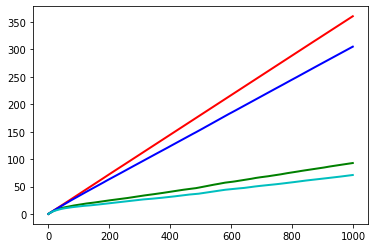

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# plt.plot(regret_random.cumsum(0), color='r', alpha=.1);
plt.plot(regret_random.cumsum(0).mean(-1), color='r', lw=2, label='random');

# plt.plot(regret_thompson.cumsum(0), color='g', alpha=.1);
plt.plot(regret_thompson.cumsum(0).mean(-1), color='g', lw=2, label='thompson');

# plt.plot(regret_fe.cumsum(0), color='b', alpha=.1);
plt.plot(regret_fe_bound.cumsum(0).mean(-1), color='b', lw=2, label='EFE bound');

# plt.plot(regret_fe.cumsum(0), color='b', alpha=.1);
plt.plot(regret_fe_exact.cumsum(0).mean(-1), color='c', lw=2, label='EFE');

In [5]:
from jax import vmap
N = 100
n = 10
trials = 600
U = np.log(np.einsum('i,ij->j', np.array([.01, .95, .04]), A3))
fixed = regret_random.cumsum(0).mean(-1)[-1]/1000

def f(gamma, name):
    local_agent = Agent(N, n, gamma=gamma, type=name, U=U)
    sequence = simulator(local_agent, process, model, N=N, trials=trials)
    correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
    regret = eps * (1 - correct)
    
    vals = regret.sum(0)/trials
    perc = np.percentile(vals, [5, 50, 95], axis=-1)
    
    return perc[0], perc[1], perc[2]

vf = np.onp.vectorize(f)

gammas = np.array([0., .25, .5, .75, 1., 1.5, 2., 3., 5., 8., 12.])
regret_rate = {'random': [fixed] * len(gammas)}
for name in ['thompson', 'EFE_bound', 'EFE_exact']:
    regret_rate[name] = vf(gammas, name)

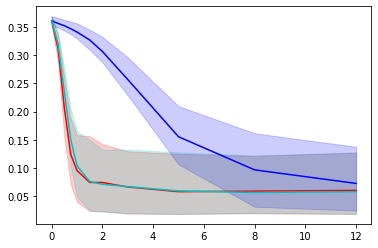

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(gammas, regret_rate['random'], 'k--')

lb, m, ub = regret_rate['thompson']
plt.plot(gammas, m, 'r')
plt.fill_between(gammas, lb, y2=ub, color='r', alpha=.2)

lb, m, ub = regret_rate['EFE_bound']
plt.plot(gammas, m, 'b')
plt.fill_between(gammas, lb, y2=ub, color='b', alpha=.2)

lb, m, ub = regret_rate['EFE_exact']
plt.plot(gammas, m, 'c')
plt.fill_between(gammas, lb, y2=ub, color='c', alpha=.2)

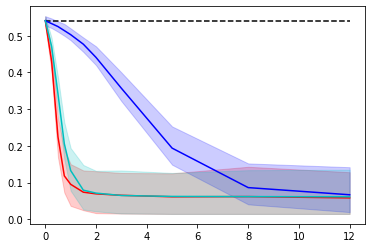

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(gammas, regret_rate['random'], 'k--')

lb, m, ub = regret_rate['thompson']
plt.plot(gammas, m, 'r')
plt.fill_between(gammas, lb, y2=ub, color='r', alpha=.2)

lb, m, ub = regret_rate['EFE_bound']
plt.plot(gammas, m, 'b')
plt.fill_between(gammas, lb, y2=ub, color='b', alpha=.2)

lb, m, ub = regret_rate['EFE_exact']
plt.plot(gammas, m, 'c')
plt.fill_between(gammas, lb, y2=ub, color='c', alpha=.2)